# Deep learning demosaicing

In [1]:
from keras.models import Model, model_from_json
from PIL import Image
import imageio
import numpy as np
import glob, os, time, random, math, sys
from keras import backend as K
from utils_test import *
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Settings

In [2]:
datasets = 'all'  # Choose the test dataset [all | kodak | mcm | hdrvdp | moire ]
model = 'our_4x4_noise-free'  # Select which model to load [our_4x4_noise-free | our_4x4_noise | bayer ]
noise_std = 0  # The noise std used (use 0 for no noise)
output_dir = None  # Specify the dir to save reconstructed images (if None, the images will not be exported)
dim_order = None  # Specify the dim order [channels_first | channels_last ] (if None, the dim order will be selected automatically)
num_displayed_images = 8  # Number of displayed images if output_dir is None

## Initialization

In [3]:
if dim_order is None:
   if (K.backend() == 'tensorflow'):
      last_channel = True
   elif (K.backend() == 'theano'):
      last_channel = False
   else:
      sys.exit('Error: unable to automatically set dim order. Please, specify one manually.')
        
elif dim_order == 'channels_first':
   last_channel = False
elif dim_order == 'channels_last':
   last_channel = True
else:
   sys.exit('Error: invalid dim_order. Choose a valid one.')


if (model == 'our_4x4_noise-free'):
   pattern_CFA = (4, 4)
   if (last_channel):
      json_file = open('trained_models/4x4_noise-free_tf.json','r')
   else:
      json_file = open('trained_models/4x4_noise-free_th.json','r')
   weights_path = 'trained_models/4x4_noise-free.h5'
   loaded_model_json = json_file.read()
   json_file.close()
   
elif (model == 'our_4x4_noise'):
   pattern_CFA = (4, 4)
   if (last_channel):
      json_file = open('trained_models/4x4_noise_tf.json','r')
   else:
      json_file = open('trained_models/4x4_noise_th.json','r')
   loaded_model_json = json_file.read()
   json_file.close()
   weights_path = 'trained_models/4x4_noise.h5'

elif (model == 'bayer'):
   pattern_CFA = (2, 2)
   if (last_channel):
      json_file = open('trained_models/2x2_bayer_tf.json','r')
   else:
      json_file = open('trained_models/2x2_bayer_th.json','r')
   loaded_model_json = json_file.read()
   json_file.close()
   weights_path = 'trained_models/2x2_bayer.h5'

else:
   sys.exit('Error: invalid model. Choose a valid model')
    
# Load model
autoencoder = model_from_json(loaded_model_json)
autoencoder.load_weights(weights_path)
print('Loaded model: ',os.path.splitext(os.path.basename(weights_path))[0])


# Load dataset
dataset_list = ['kodak','mcm','hdrvdp','moire']
if (datasets in dataset_list):
   dataset_list = [datasets]
elif (datasets != 'all'):
   sys.exit('Error: invalid dataset. Please specify a valid dataset')

Loaded model:  4x4_noise-free


## Run demosaicer

Starting predictions on datasets:  all
kodak - PSNR: 43.70;	 Time: 4.24 s


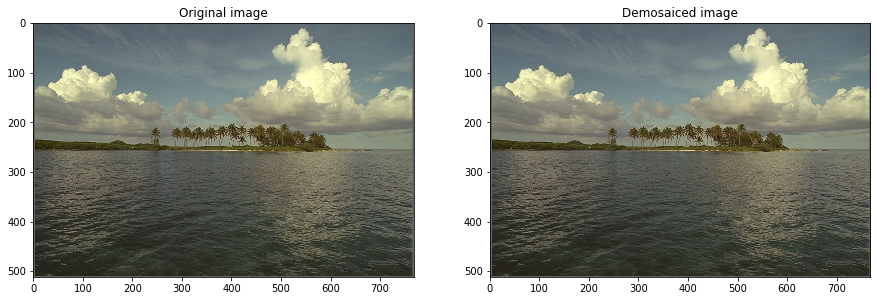

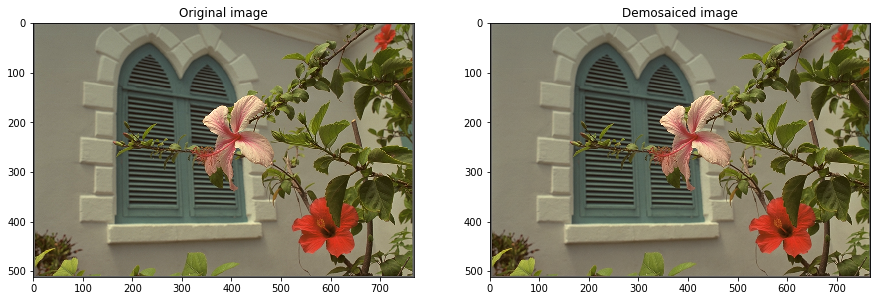

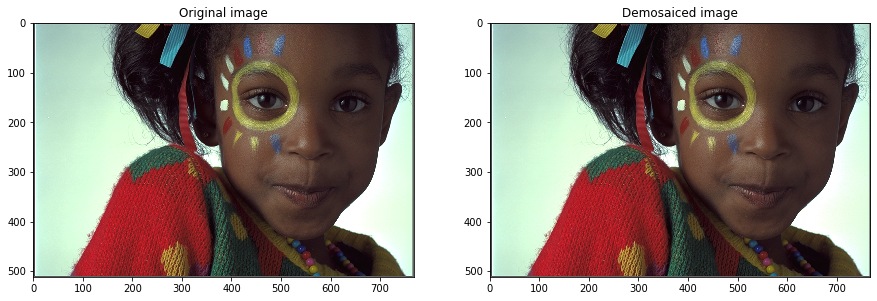

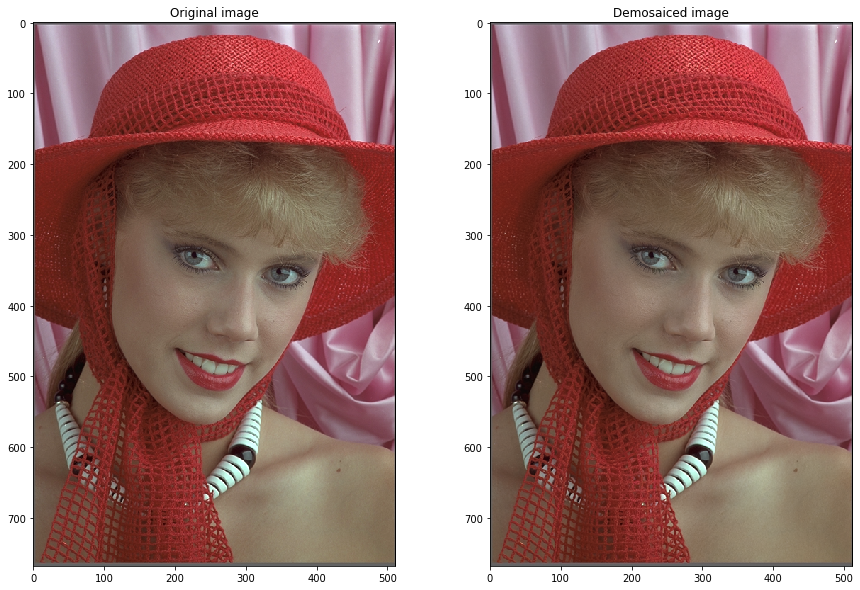

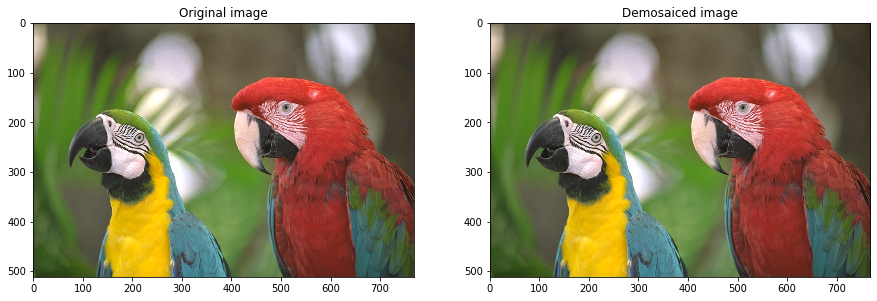

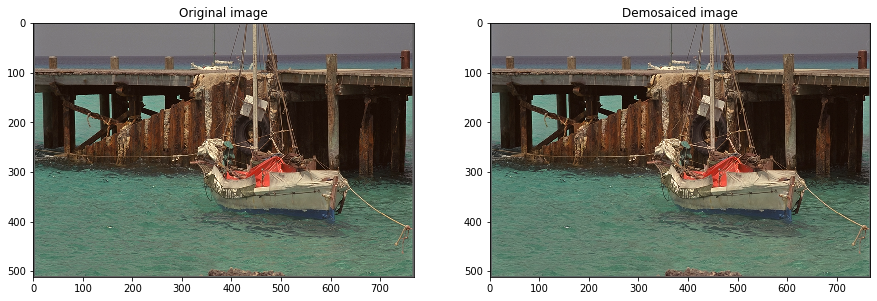

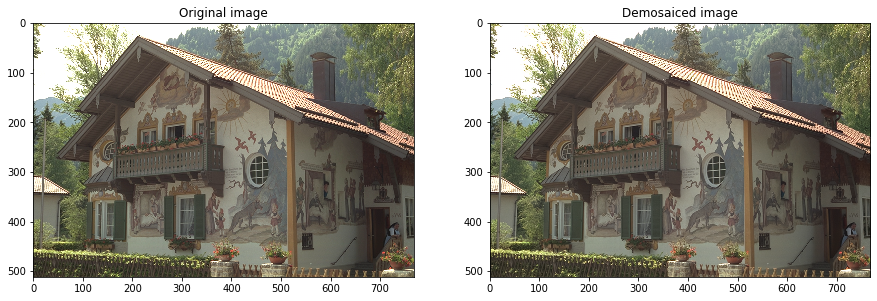

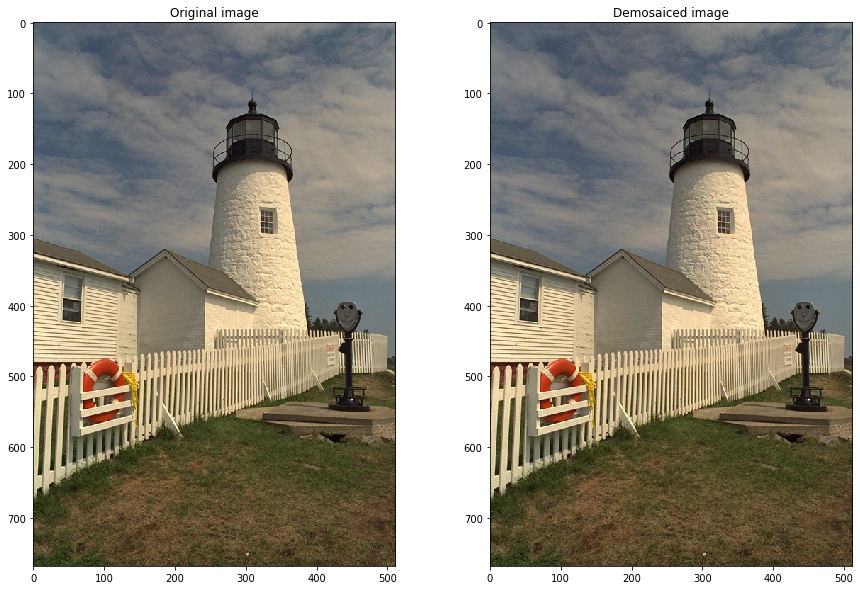

In [4]:
print('Starting predictions on datasets: ',str(datasets))

if (output_dir is not None):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
idx = 0
for cur_dataset in dataset_list:
   
    if (output_dir is not None):
        cur_output_dir = output_dir + '/' + cur_dataset
        if not os.path.exists(cur_output_dir):
            os.makedirs(cur_output_dir)
            
    elif idx >= num_displayed_images:
        break
            
    imgs = glob.glob('datasets/' + cur_dataset + '/*')    
    if output_dir is None:
        imgs = imgs[:num_displayed_images]
    psnrs = np.zeros((len(imgs)))
    times = np.zeros((len(imgs)))
    for i, img_name in enumerate(imgs):
        img = np.asarray(Image.open(img_name)).astype('float32')
        if noise_std > 0:
            predicted, times[i] = predictImgNoise(img, autoencoder, pattern_CFA, noise_std, not last_channel)
        
        else:
            predicted, times[i] = predictImg(img, autoencoder, pattern_CFA, not last_channel)
            
        psnrs[i] = cpsnr(img, predicted)
        
        if (output_dir is not None):
            imageio.imwrite(img_name.replace('datasets', output_dir), predicted)
            
        else:
            if idx < num_displayed_images:
                plt.figure(figsize=(15,10))
                plt.subplot(121)
                plt.imshow(img.astype(np.uint8))
                plt.title('Original image')
                plt.subplot(122)
                plt.imshow(predicted.astype(np.uint8))
                plt.title('Demosaiced image')
                idx += 1
            else:
                break
        
    print("{:s} - PSNR: {:.2f};\t Time: {:.2f} s".format(cur_dataset, np.mean(psnrs), np.mean(reject_outliers(times))))